# Understanding Modularity in Network Community Detection

This notebook provides an in-depth exploration of modularity, a key metric used in community detection algorithms for complex networks. We'll cover the theoretical foundations, mathematical formulations, implementations in NetworkX, and practical examples using real-world networks including the famous Zachary's Karate Club network.

## Learning Objectives

By the end of this notebook, you will understand:
- What modularity is and why it's important for community detection
- How to mathematically calculate modularity
- Different formulations of modularity for various types of networks
- The limitations of modularity (resolution limit, degeneracy, etc.)
- How to implement modularity calculations using NetworkX
- How to interpret modularity scores in real network analysis

## 1. Setting Up Our Environment

First, let's import the necessary libraries for our analysis:

In [109]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import random
import time

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configure plot settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8-whitegrid')

# Use Pastel1 colormap for all visualizations
pastel_cmap = plt.cm.Pastel1

# Import community detection algorithms
from networkx.algorithms.community import modularity
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import label_propagation_communities
from networkx.algorithms.community import asyn_fluidc



## 2. Modularity: Theoretical Foundation

### 2.1 What is Modularity?

**Modularity** is a measure of the quality of a network partition into communities. It quantifies the difference between:
- The actual density of connections within communities
- The expected density if connections were distributed randomly while maintaining the same degree distribution

The core idea is to compare the real network structure against a null model where community structure is absent but other structural properties (like degree distribution) are preserved.

### 2.2 Mathematical Definition

For an undirected, unweighted network, modularity (Q) is defined as:

$$Q = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where:
- $A_{ij}$ is the adjacency matrix element (1 if nodes $i,j$ are connected, 0 otherwise)
- $k_i, k_j$ are the degrees of nodes $i$ and $j$
- $m$ is the total number of edges in the network
- $\delta(c_i, c_j)$ is 1 if nodes $i$ and $j$ belong to the same community, 0 otherwise
- $\frac{k_i k_j}{2m}$ is the expected number of edges between nodes $i$ and $j$ in the null model (Configuration Model)

### 2.3 Community-Based Formulation

We can rewrite the modularity formula in terms of communities:

$$Q = \sum_{C} \left[ \frac{L_C}{m} - \left(\frac{k_C}{2m}\right)^2 \right]$$

Where:
- $L_C$ is the number of links within community $C$
- $k_C$ is the sum of the degrees of all nodes in community $C$
- $m$ is the total number of links in the network

### 2.4 Understanding the Null Model

The term $\frac{k_i k_j}{2m}$ in the modularity equation represents the probability of an edge existing between nodes $i$ and $j$ in a **random network** that:
1. Has the same number of nodes as the original network
2. Preserves the degree sequence of the original network (each node maintains its degree)
3. Places edges randomly with this constraint

This is the **Configuration Model**, a random graph model where:
- Each node has the same number of "stubs" (half-edges) as its degree in the original network
- Stubs are paired randomly to form complete edges

In [110]:
# Create a small example network to illustrate the configuration model
def create_small_network():
    G = nx.Graph()
    G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])
    return G

G_small = create_small_network()

# Create a configuration model version
degrees = [d for n, d in G_small.degree()]
G_config = nx.configuration_model(degrees, seed=42)
G_config = nx.Graph(G_config)  # Remove parallel edges
G_config.remove_edges_from(nx.selfloop_edges(G_config))  # Remove self-loops

# Relabel nodes to match original network
mapping = {i: list(G_small.nodes())[i] for i in range(len(G_small))}
G_config = nx.relabel_nodes(G_config, mapping)

# Calculate the expected number of edges between nodes in the configuration model
m = G_small.number_of_edges()
edge_probabilities = {}
for i in G_small.nodes():
    for j in G_small.nodes():
        if i < j:  # Avoid counting twice for undirected graph
            ki = G_small.degree(i)
            kj = G_small.degree(j)
            expected = (ki * kj) / (2 * m)
            actual = 1 if G_small.has_edge(i, j) else 0
            edge_probabilities[(i, j)] = {"actual": actual, "expected": expected}

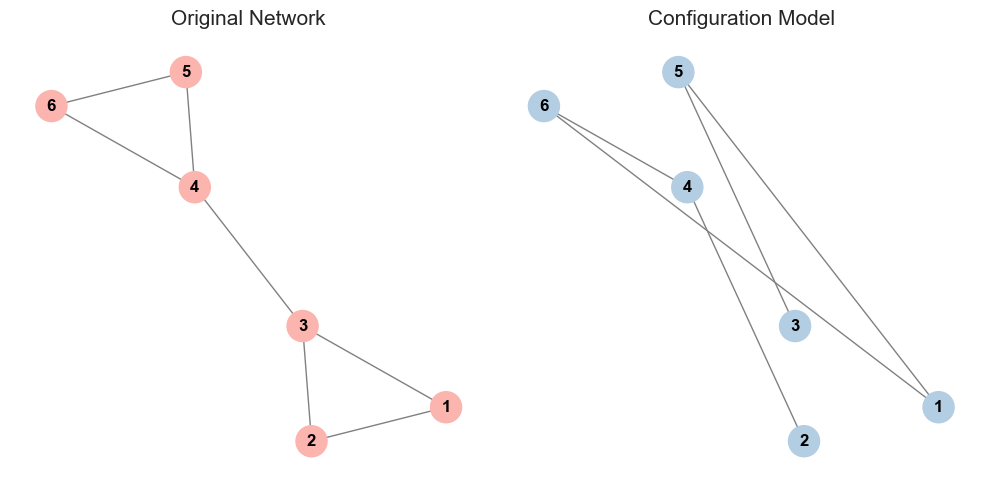

Edge probabilities in the configuration model:
Nodes 1-2: Actual=1, Expected=0.2857
Nodes 1-3: Actual=1, Expected=0.4286
Nodes 1-4: Actual=0, Expected=0.4286
Nodes 1-5: Actual=0, Expected=0.2857
Nodes 1-6: Actual=0, Expected=0.2857
Nodes 2-3: Actual=1, Expected=0.4286
Nodes 2-4: Actual=0, Expected=0.4286
Nodes 2-5: Actual=0, Expected=0.2857
Nodes 2-6: Actual=0, Expected=0.2857
Nodes 3-4: Actual=1, Expected=0.6429
Nodes 3-5: Actual=0, Expected=0.4286
Nodes 3-6: Actual=0, Expected=0.4286
Nodes 4-5: Actual=1, Expected=0.4286
Nodes 4-6: Actual=1, Expected=0.4286
Nodes 5-6: Actual=1, Expected=0.2857


In [111]:
# Visualize the original network and configuration model
plt.figure(figsize=(10, 5))

# Original network
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos, with_labels=True, 
        node_color=[pastel_cmap(0)] * len(G_small), 
        node_size=500, font_weight='bold', edge_color='gray')
plt.title("Original Network", fontsize=15)

# Configuration model
plt.subplot(1, 2, 2)
nx.draw(G_config, pos, with_labels=True, 
        node_color=[pastel_cmap(1)] * len(G_config), 
        node_size=500, font_weight='bold', edge_color='gray')
plt.title("Configuration Model", fontsize=15)

plt.tight_layout()
plt.show()

# Display the expected edge probabilities
print("Edge probabilities in the configuration model:")
for edge, values in edge_probabilities.items():
    print(f"Nodes {edge[0]}-{edge[1]}: Actual={values['actual']}, Expected={values['expected']:.4f}")

### 2.5 Interpreting Modularity Values

- **Q = 0**: The community structure is no better than random
- **Q < 0**: The community structure is worse than random (communities are less densely connected internally than would be expected by chance)
- **Q > 0**: The network has more connections within communities than would be expected in a random network
- **Q ≈ 0.3-0.7**: Typical range for networks with strong community structure
- **Q < 1**: Theoretical upper bound (practically never reached)

Modularity is always calculated with respect to a specific partition of the network into communities.

## 3. Calculating Modularity with NetworkX

NetworkX provides built-in functions to calculate modularity. Let's explore these functions using some example networks.

In [112]:
# Create the Zachary's Karate Club network - a classic benchmark for community detection
karate = nx.karate_club_graph()

# Let's define some sample communities
# For example, split by club allegiance (instructor vs administrator)
instructor_community = {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21}
administrator_community = {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}

# Calculate modularity
communities = [instructor_community, administrator_community]
Q = modularity(karate, communities)

print(f"Zachary's Karate Club network:")
print(f"Nodes: {karate.number_of_nodes()}, Edges: {karate.number_of_edges()}")
print(f"Modularity of the two-community partition: {Q:.4f}")

# Let's also try some other community structures
# Random assignment - should have lower modularity
random.seed(42)
random_communities = [set(), set()]
for node in karate.nodes():
    random_communities[random.randint(0, 1)].add(node)

Q_random = modularity(karate, random_communities)
print(f"Modularity of random communities: {Q_random:.4f}")

# Single community - should have 0 modularity
single_community = [set(karate.nodes())]
Q_single = modularity(karate, single_community)
print(f"Modularity of a single community: {Q_single:.4f}")

Zachary's Karate Club network:
Nodes: 34, Edges: 78
Modularity of the two-community partition: 0.3914
Modularity of random communities: 0.1093
Modularity of a single community: 0.0000


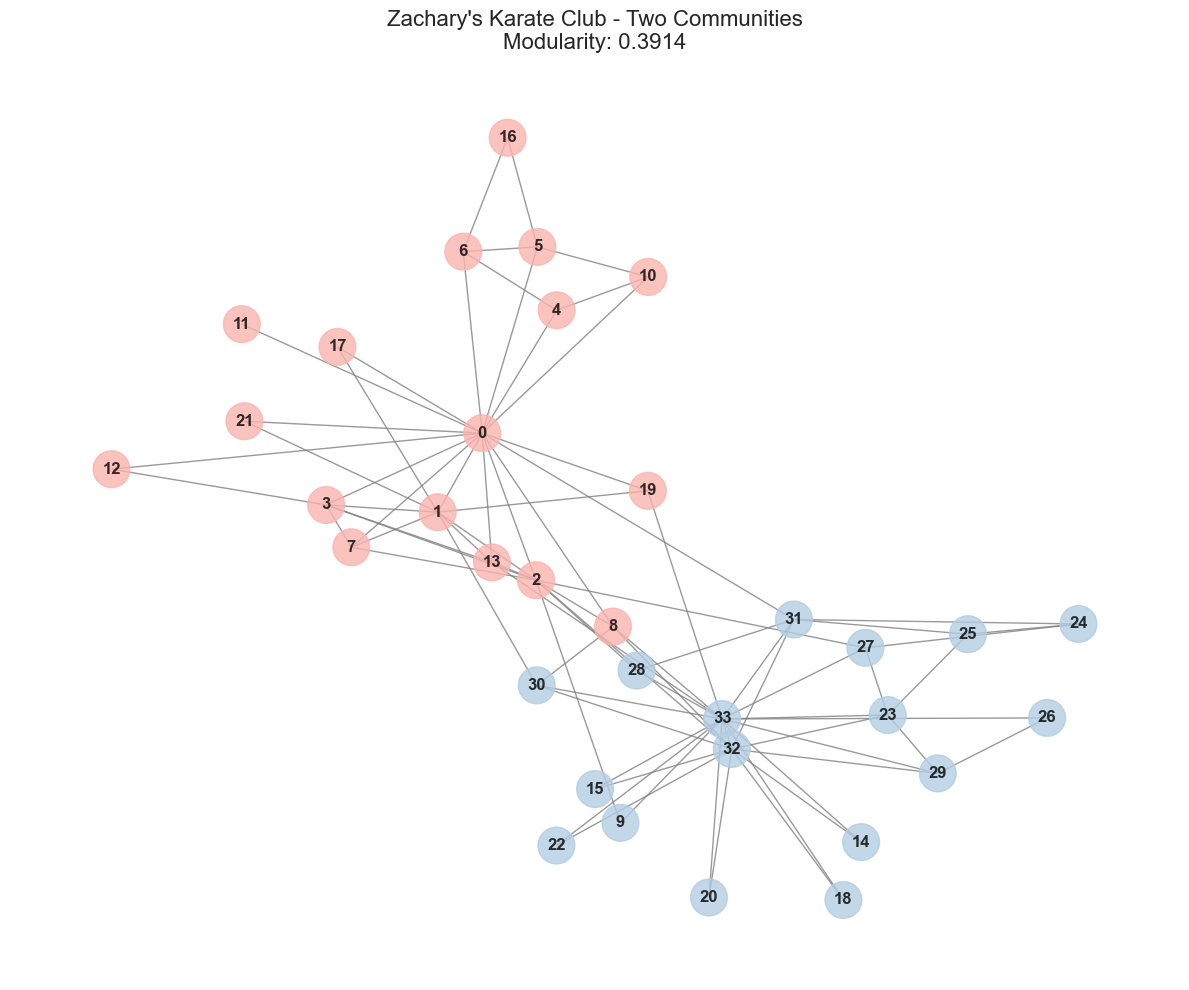

In [113]:
# Visualize the Karate Club network with community structure
plt.figure(figsize=(12, 10))

# Layout
pos = nx.spring_layout(karate, seed=42)

# Colors for different communities using Pastel1 colormap
community_colors = []
for node in karate.nodes():
    if node in instructor_community:
        community_colors.append(pastel_cmap(0))
    else:
        community_colors.append(pastel_cmap(1))

# Draw the network
nx.draw_networkx(karate, pos, 
                 node_color=community_colors,
                 node_size=700,
                 with_labels=True,
                 font_weight='bold',
                 edge_color='gray',
                 alpha=0.8)

plt.title(f"Zachary's Karate Club - Two Communities\nModularity: {Q:.4f}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Modularity Limitations

Despite its popularity, modularity has several important limitations:

### 5.1 Resolution Limit

One of the most significant limitations of modularity is the **resolution limit**. Modularity optimization cannot detect communities smaller than a certain scale, which depends on the total size of the network.

Specifically, communities with fewer than ~$\sqrt{2E}$ edges (where $E$ is the total number of edges in the network) tend to be merged together, even if they are well-defined communities.

### 5.2 Degeneracy

Another limitation of modularity is **degeneracy** - the existence of multiple different partitions with similar modularity values. This means that small perturbations in the network or the algorithm can lead to substantially different community assignments.

### 5.3 Other Limitations

1. **Lack of a universal threshold**: There's no universal threshold for a "good" modularity value. A value of 0.3 might be significant in one network but not in another.

2. **Random networks can have high modularity**: Even random graphs without actual community structure can yield partitions with relatively high modularity values.

3. **Local optimization trap**: Most modularity optimization algorithms are greedy and can get stuck in local optima.

4. **Scaling with network size**: Modularity tends to scale with network size, making it difficult to compare modularity values across networks of different sizes.

In [114]:
# Let's demonstrate some of the limitations of modularity

# 1. Resolution limit demonstration
# Create a network with clear small communities
def create_ring_of_cliques(num_cliques, clique_size):
    """Create a ring of cliques - a network with well-defined small communities"""
    G = nx.Graph()
    
    # Add cliques (complete subgraphs)
    for i in range(num_cliques):
        clique_nodes = [i * clique_size + j for j in range(clique_size)]
        G.add_edges_from(nx.complete_graph(clique_nodes).edges())
    
    # Connect the cliques in a ring
    for i in range(num_cliques):
        G.add_edge(i * clique_size, ((i + 1) % num_cliques) * clique_size)
    
    return G

# Create a ring of 10 cliques, each with 5 nodes
ring_of_cliques = create_ring_of_cliques(10, 5)

# The ground truth communities are the cliques
ground_truth = [set(range(i * 5, (i + 1) * 5)) for i in range(10)]

# Apply greedy modularity optimization
ring_communities = list(greedy_modularity_communities(ring_of_cliques))

# Compare number of communities
print(f"Ground truth communities: {len(ground_truth)}")
print(f"Communities found by modularity optimization: {len(ring_communities)}")
print(f"Modularity score: {modularity(ring_of_cliques, ring_communities):.4f}")



Ground truth communities: 10
Communities found by modularity optimization: 10
Modularity score: 0.8091


In [115]:
# 2. Degeneracy demonstration 
# Create a network with ambiguous community structure that can lead to multiple valid partitions
def create_network_with_ambiguous_communities(n_clusters=3, nodes_per_cluster=10, p_in=0.7, p_between=0.05, seed=None):
    """Create a network with somewhat ambiguous community structure"""
    G = nx.Graph()
    # Add all nodes
    total_nodes = n_clusters * nodes_per_cluster
    G.add_nodes_from(range(total_nodes))
    
    # Add intra-community edges with high probability
    for c in range(n_clusters):
        nodes = range(c * nodes_per_cluster, (c + 1) * nodes_per_cluster)
        for i in nodes:
            for j in nodes:
                if i < j and random.random() < p_in:
                    G.add_edge(i, j)
    
    # Add inter-community edges with low probability
    for i in range(total_nodes):
        for j in range(total_nodes):
            c1 = i // nodes_per_cluster
            c2 = j // nodes_per_cluster
            if c1 != c2 and i < j and random.random() < p_between:
                G.add_edge(i, j)
    
    return G

# Set seed for reproducibility of initial network
random.seed(42)
G_ambiguous = create_network_with_ambiguous_communities(n_clusters=3, nodes_per_cluster=10, p_in=0.5, p_between=0.1)

# Try multiple runs with different perturbations to the network
num_runs = 5
modularity_values = []
community_counts = []
partitions = []

for i in range(num_runs):
    # Create a slightly perturbed version of the network
    # by randomly rewiring some edges
    G_perturbed = G_ambiguous.copy()
    
    # Add noise: randomly add or remove a few edges
    random.seed(42 + i)  # Different seed for each perturbation
    n_changes = int(G_perturbed.number_of_edges() * 0.05)  # Change 5% of edges
    
    # Add some random edges
    for _ in range(n_changes):
        a, b = random.sample(list(G_perturbed.nodes()), 2)
        if not G_perturbed.has_edge(a, b):
            G_perturbed.add_edge(a, b)
    
    # Remove some random edges
    edges = list(G_perturbed.edges())
    for _ in range(min(n_changes, len(edges))):
        edge = random.choice(edges)
        G_perturbed.remove_edge(*edge)
        edges.remove(edge)
    
    # Shuffle node order to influence greedy algorithm's behavior
    # Create a shuffled copy for processing
    node_list = list(G_perturbed.nodes())
    random.shuffle(node_list)
    
    # Run community detection with shuffled node processing
    # (no seed parameter needed anymore)
    communities = list(greedy_modularity_communities(G_perturbed))
    mod_value = modularity(G_perturbed, communities)
    
    # Create a partition dictionary for visualization
    partition = {}
    for comm_idx, community in enumerate(communities):
        for node in community:
            partition[node] = comm_idx
    
    modularity_values.append(mod_value)
    community_counts.append(len(communities))
    partitions.append(partition)
    
    print(f"Run {i+1}: {len(communities)} communities with modularity {mod_value:.4f}")

# Calculate variation metrics
mod_variance = np.var(modularity_values)
nmi_values = []

# Calculate Normalized Mutual Information between all pairs of partitions
from sklearn.metrics import normalized_mutual_info_score

for i in range(num_runs):
    for j in range(i+1, num_runs):
        partition_i = [partitions[i].get(node, -1) for node in range(max(partitions[i].keys())+1)]
        partition_j = [partitions[j].get(node, -1) for node in range(max(partitions[j].keys())+1)]
        nmi = normalized_mutual_info_score(partition_i, partition_j)
        nmi_values.append(nmi)

# Print variation statistics
print(f"\nModularity values range: {min(modularity_values):.4f} - {max(modularity_values):.4f}")
print(f"Modularity variance: {mod_variance:.6f}")
print(f"Community count range: {min(community_counts)} - {max(community_counts)}")
print(f"Average NMI between partitions: {np.mean(nmi_values):.4f} (1.0 = identical, 0.0 = completely different)")

Run 1: 3 communities with modularity 0.3714
Run 2: 3 communities with modularity 0.3504
Run 3: 3 communities with modularity 0.3770
Run 4: 4 communities with modularity 0.3499
Run 5: 4 communities with modularity 0.3307

Modularity values range: 0.3307 - 0.3770
Modularity variance: 0.000277
Community count range: 3 - 4
Average NMI between partitions: 0.7921 (1.0 = identical, 0.0 = completely different)


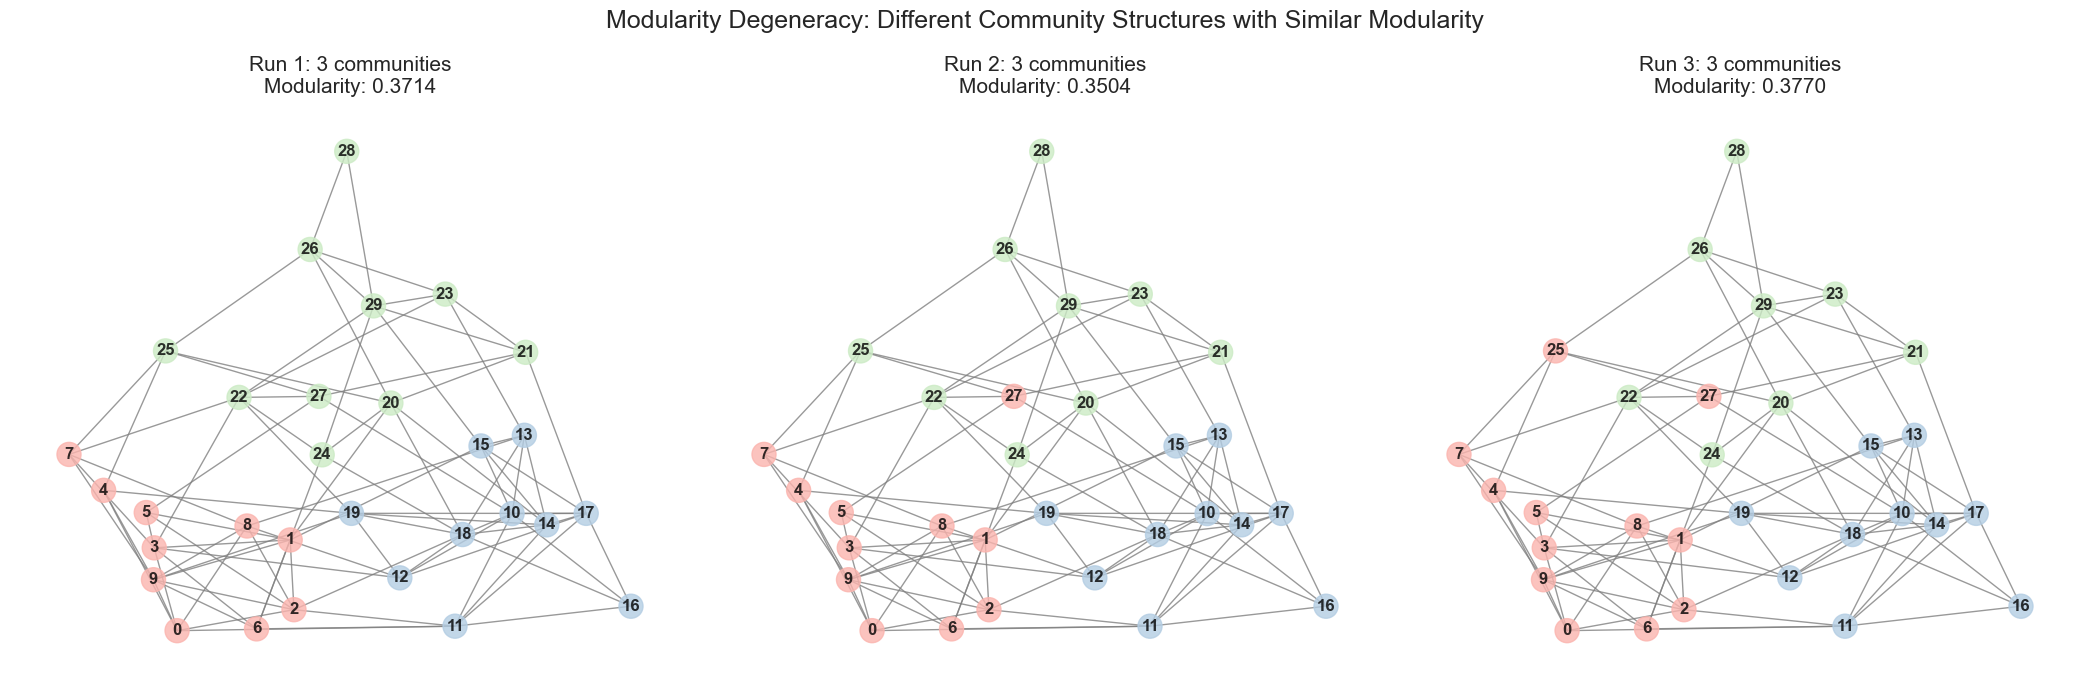

In [116]:
# Visualize the degeneracy issue by showing different community structures
# Plot 3 different partitions side by side to see the differences
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# Create a layout for the ambiguous network
pos_ambiguous = nx.spring_layout(G_ambiguous, seed=42)

for i in range(min(3, num_runs)):
    # Get the node colors based on community assignment
    colors = [pastel_cmap(partitions[i][node] % 9) for node in G_ambiguous.nodes()]
    
    # Draw the network
    nx.draw_networkx(G_ambiguous, pos_ambiguous, 
                    node_color=colors, 
                    node_size=300, 
                    with_labels=True,
                    font_weight='bold',
                    edge_color='gray',
                    alpha=0.8,
                    ax=axes[i])
    
    axes[i].set_title(f"Run {i+1}: {community_counts[i]} communities\nModularity: {modularity_values[i]:.4f}", 
                    fontsize=15)
    axes[i].axis('off')

plt.suptitle("Modularity Degeneracy: Different Community Structures with Similar Modularity", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

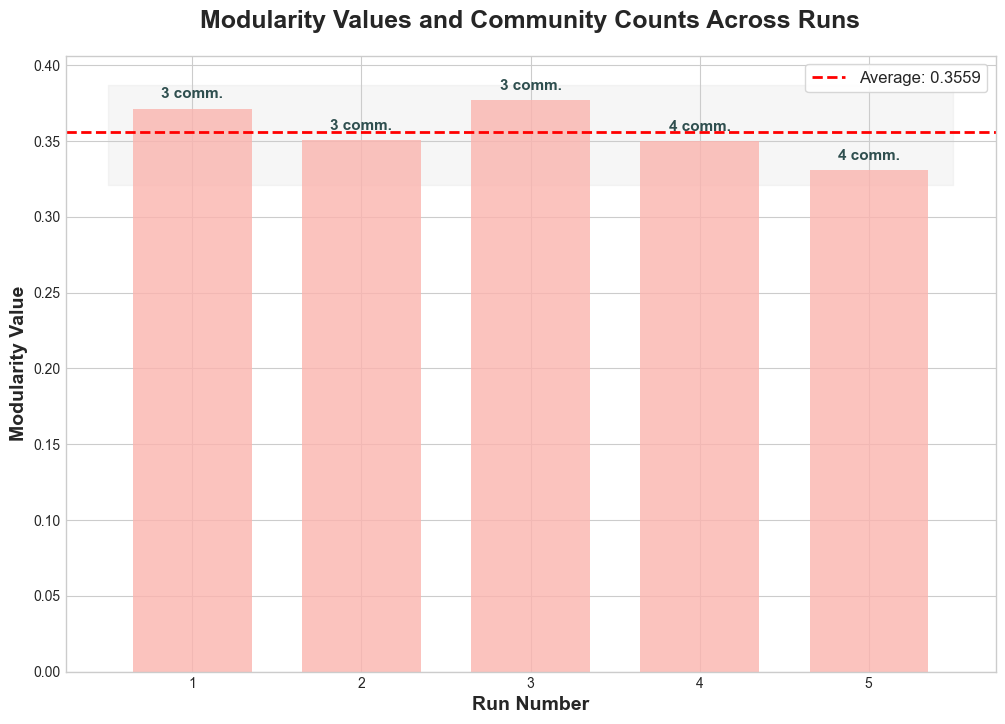

In [117]:
# Create a figure and axis with an improved OO approach
fig, ax = plt.subplots()

# Create the bar chart with improved styling
bars = ax.bar(range(1, num_runs+1), modularity_values, 
             color=[pastel_cmap(0)],  
             linewidth=1.5,
             alpha=0.8,
             width=0.7)

# Add community count labels on top of each bar
for i, (bar, count) in enumerate(zip(bars, community_counts)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
           f"{count} comm.", ha='center', va='bottom', fontsize=11,
           fontweight='bold', color='darkslategray')

# Add a horizontal line for the average modularity
mean_modularity = np.mean(modularity_values)
ax.axhline(y=mean_modularity, color='red', linestyle='--', linewidth=2, 
          label=f'Average: {mean_modularity:.4f}')

# Add a filled region to highlight variance
y_min = np.min(modularity_values) - 0.01
y_max = np.max(modularity_values) + 0.01
ax.fill_between([0.5, num_runs + 0.5], y_min, y_max, 
               color='lightgray', alpha=0.2, zorder=0)

# Configure plot elements
ax.set_xlabel('Run Number', fontsize=14, fontweight='bold')
ax.set_ylabel('Modularity Value', fontsize=14, fontweight='bold')
ax.set_title('Modularity Values and Community Counts Across Runs', 
            fontsize=18, fontweight='bold', pad=20)
ax.set_xticks(range(1, num_runs+1))

# Add legend with styled box
ax.legend(loc='upper right', frameon=True, framealpha=0.9, 
         fontsize=12, facecolor='white', edgecolor='lightgray')
plt.show()

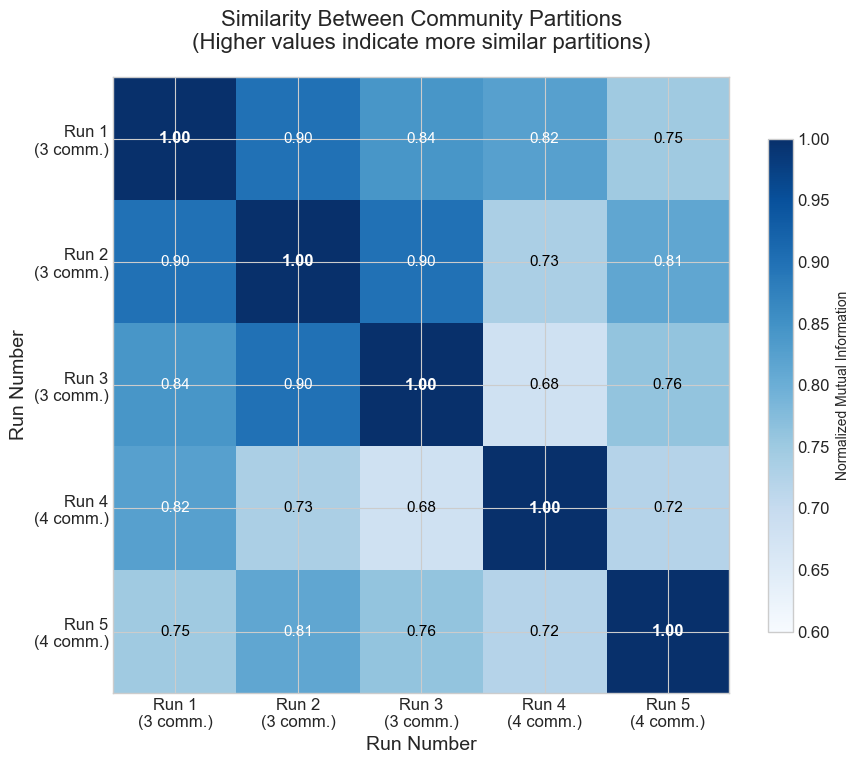

In [118]:
# Visualize the similarity between partitions as a heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Create a matrix of NMI values (similarity between different partitions)
nmi_matrix = np.ones((num_runs, num_runs))
idx = 0
for i in range(num_runs):
    for j in range(i+1, num_runs):
        nmi_matrix[i, j] = nmi_matrix[j, i] = nmi_values[idx]
        idx += 1

# Create a mask for the diagonal (always 1.0)
mask = np.eye(num_runs, dtype=bool)

# Plot the heatmap with improved styling
cmap = plt.cm.Blues
im = ax.imshow(nmi_matrix, cmap=cmap, vmin=0.6, vmax=1)  # Adjusted vmin to highlight differences

# Add colorbar with better formatting
cbar = fig.colorbar(im, ax=ax, label='Normalized Mutual Information', shrink=0.8)
cbar.ax.tick_params(labelsize=12)

# Add title and labels with better formatting
ax.set_title('Similarity Between Community Partitions\n(Higher values indicate more similar partitions)', 
             fontsize=16, pad=20)
ax.set_xlabel('Run Number', fontsize=14)
ax.set_ylabel('Run Number', fontsize=14)

# Customize axis ticks
run_labels = [f'Run {i+1}\n({community_counts[i]} comm.)' for i in range(num_runs)]
ax.set_xticks(range(num_runs))
ax.set_yticks(range(num_runs))
ax.set_xticklabels(run_labels, fontsize=12)
ax.set_yticklabels(run_labels, fontsize=12)

# Add text annotations with conditional formatting
for i in range(num_runs):
    for j in range(num_runs):
        # Skip the diagonal or use different formatting
        if i == j:
            ax.text(j, i, "1.00", ha='center', va='center', 
                   fontsize=12, color='white', fontweight='bold')
        else:
            color = 'white' if nmi_matrix[i, j] > 0.8 else 'black'
            ax.text(j, i, f'{nmi_matrix[i, j]:.2f}', 
                   ha='center', va='center', 
                   fontsize=11, color=color)

plt.show()



## 6. Resolution Parameter

To address the resolution limit problem, some modularity optimization methods include a resolution parameter that can be adjusted:

$$Q_\gamma = \frac{1}{2m}\sum_{i,j} \left[ A_{ij} - \gamma \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$$

Where $\gamma$ is the resolution parameter:
- $\gamma > 1$ yields smaller communities (higher resolution)
- $\gamma < 1$ yields larger communities (lower resolution)

Let's see how different resolution values affect community detection:

In [119]:
# Explore different resolution parameters with greedy modularity communities
resolution_values = [0.5, 1.0, 2.0, 5.0]
results = []

for resolution in resolution_values:
    communities = list(greedy_modularity_communities(karate, resolution=resolution))
    
    # Calculate modularity
    mod = modularity(karate, communities)
    
    # Create a partition dictionary for visualization
    partition = {}
    for i, community in enumerate(communities):
        for node in community:
            partition[node] = i
    
    results.append({
        'resolution': resolution,
        'num_communities': len(communities),
        'modularity': mod,
        'partition': partition,
        'communities': communities
    })
    
    print(f"Resolution {resolution}: Found {len(communities)} communities with modularity {mod:.4f}")

Resolution 0.5: Found 2 communities with modularity 0.3477
Resolution 1.0: Found 3 communities with modularity 0.4110
Resolution 2.0: Found 7 communities with modularity 0.3276
Resolution 5.0: Found 18 communities with modularity 0.1674


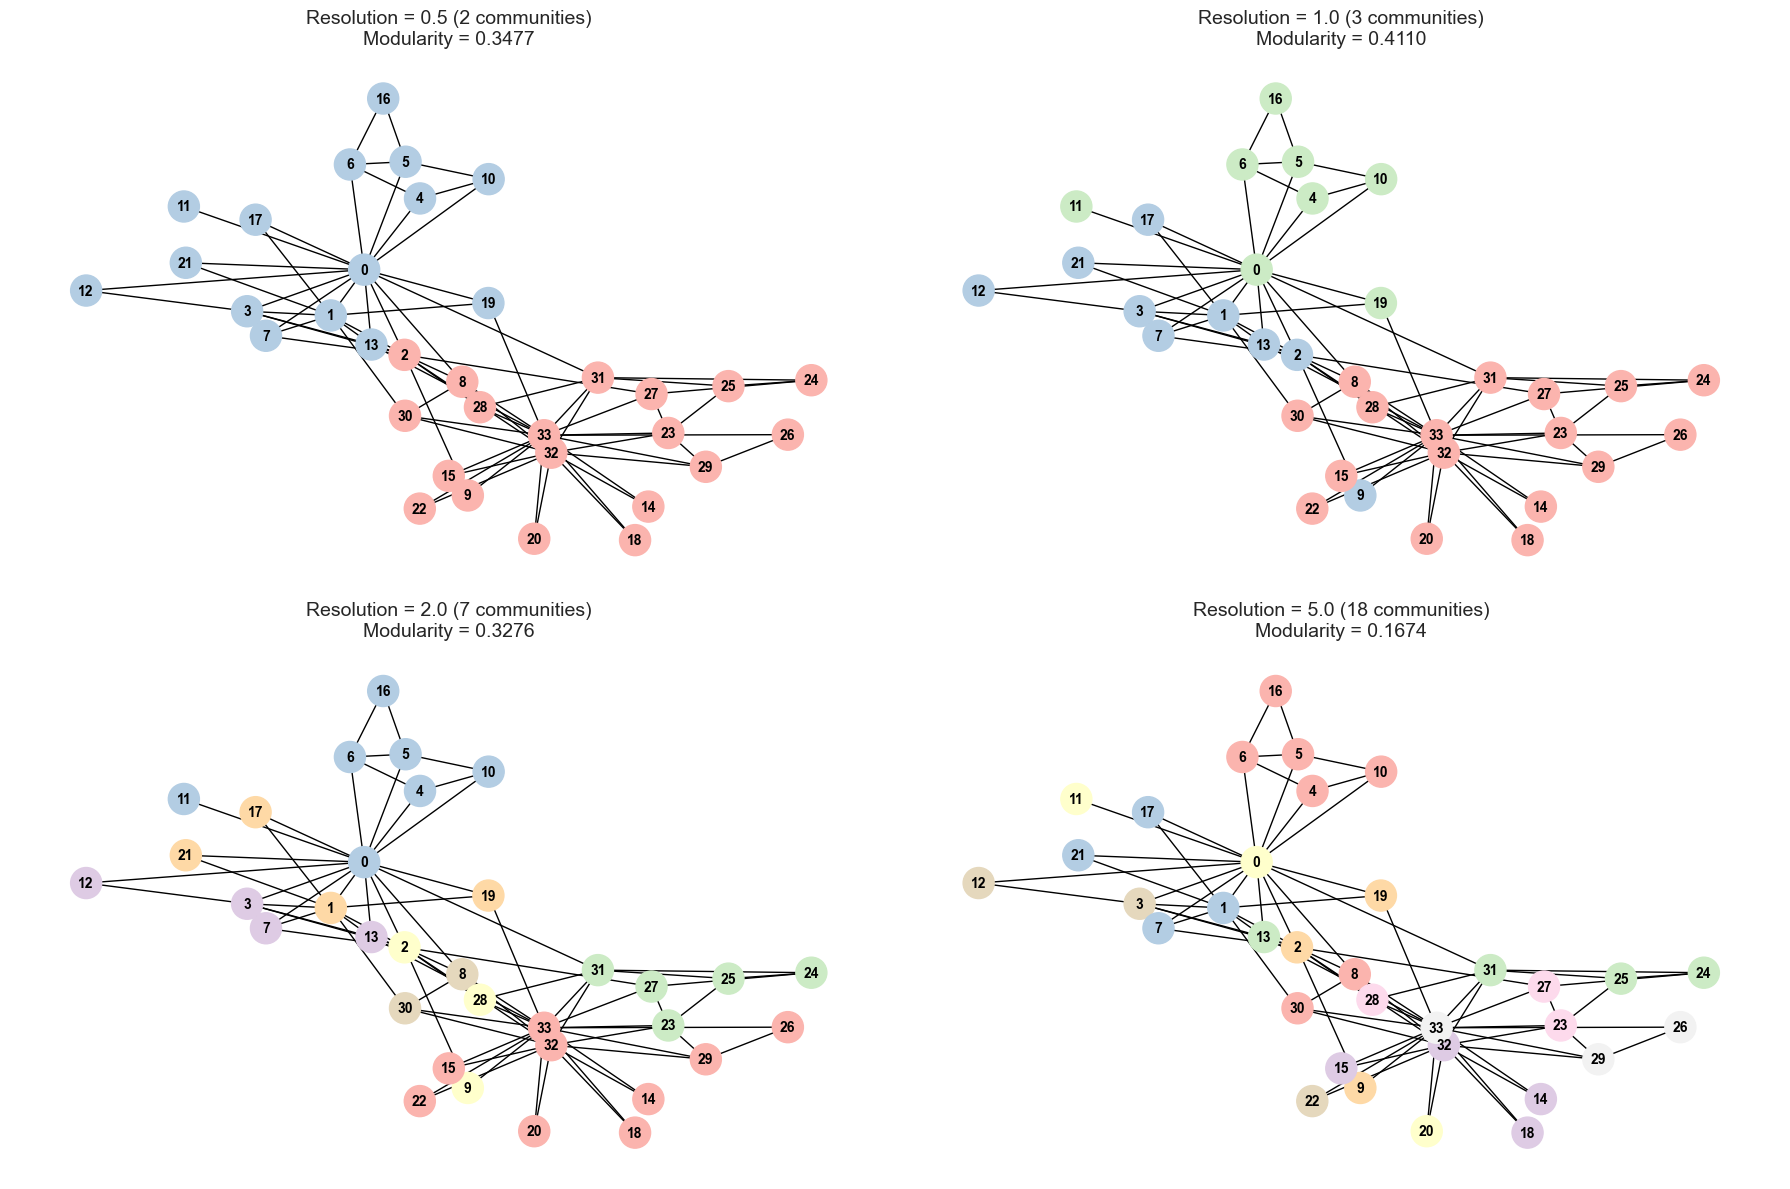

In [120]:
# Visualize the effect of resolution parameter
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# Define positions for all nodes (important to do this outside the loop)
pos = nx.spring_layout(karate, seed=42)

for i, result in enumerate(results):
    res = result['resolution']
    colors = [pastel_cmap(result['partition'][node] % 9) for node in karate.nodes()]
    
    nx.draw_networkx(karate, pos, node_color=colors, node_size=500, with_labels=True, 
                    font_size=10, font_weight='bold', ax=axes[i])
    axes[i].set_title(f"Resolution = {res} ({result['num_communities']} communities)\nModularity = {result['modularity']:.4f}", 
                     fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()



## 8. Summary

In this notebook, we've explored modularity in depth:

- **What modularity is**: A quality function that measures how well a network is partitioned into communities by comparing the actual structure to a random null model

- **Mathematical formulations**: We examined different ways to calculate modularity for various types of networks

- **Implementation**: We used NetworkX's built-in functions to calculate and optimize modularity

- **Extensions**: We explored how modularity can be adapted for directed and weighted networks

- **Limitations**: We demonstrated key limitations including resolution limit, degeneracy, and issues with random networks

- **Resolution parameter**: We showed how adjusting the resolution parameter affects community detection

- **Practical usage**: We provided practical recommendations for using modularity in real-world network analysis

Modularity remains one of the most popular quality functions for community detection despite its limitations. Understanding its strengths and weaknesses is crucial for properly interpreting the results of community detection algorithms.

## 9. References

1. Newman, M. E. J. & Girvan, M. (2004). Finding and evaluating community structure in networks. Physical Review E, 69(2), 026113.

2. Clauset, A., Newman, M. E. J., & Moore, C. (2004). Finding community structure in very large networks. Physical Review E, 70(6), 066111.

3. Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008(10), P10008.

4. Fortunato, S., & Barthélemy, M. (2007). Resolution limit in community detection. Proceedings of the National Academy of Sciences, 104(1), 36-41.

5. Newman, M. E. J. (2006). Modularity and community structure in networks. Proceedings of the National Academy of Sciences, 103(23), 8577-8582.

6. Fortunato, S. (2010). Community detection in graphs. Physics Reports, 486(3-5), 75-174.